In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from dask_image import imread

from cil.framework import AcquisitionGeometry
from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.recon import FDK


### Path to Battery tiff dataset

In [2]:
path = r"Z:\Users\Antony\RSIF\microct\Imperial\Energizer_AAA_binning1_1s_ROI_3600\Scan2"
name = "Energizer_AAA_binning1_1s_ROI_3600_middle_and_top0*.tif"
data_dask = imread.imread(os.path.join(path, name)).astype("float32")


C:\Users\Simon\anaconda3\envs\ndtomo_cil\Lib\site-packages\pims\image_sequence.py:85: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  return imread(filename, **kwargs)


In [3]:
data_dask

dask.array<astype, shape=(3601, 2304, 2284), dtype=float32, chunksize=(1, 2304, 2284), chunktype=numpy.ndarray>

In [4]:
num_pixels_y = 2284
num_pixels_x = 2304

FDD=332.99937500
FOD=30.99937500
VoxelSizeX=0.05
VoxelSizeY=0.05

angles_list = np.linspace(-np.pi, np.pi, 3600, endpoint=False)

ag = AcquisitionGeometry.create_Cone3D( source_position=[0.0, -FOD, 0.0], \
                                        detector_position=[0., FDD , 0.],\
                                        rotation_axis_position=[0, 0., 0.],\
                                        rotation_axis_direction=[0., 0, np.pi] ) \
                        .set_angles(angles = angles_list, angle_unit='radian')\
                        .set_panel( num_pixels=[num_pixels_y, num_pixels_x], \
                                    pixel_size=[VoxelSizeX, VoxelSizeY],\
                                    origin='top-right')\
                        .set_labels(['angle','vertical','horizontal'])


ig = ag.get_ImageGeometry()


In [5]:
data = ag.allocate(None)


In [6]:
data_np = data_dask.compute()


In [7]:
data.fill(data_np[0:3600])

In [8]:
absorb = TransmissionAbsorptionConverter(min_intensity=1e-6)
absorb.set_input(data)
data_absorbed = absorb.get_output()

In [9]:
data_absorbed -= np.mean(data_absorbed.array[0:100,:,0:10])

In [10]:


data_absorbed.geometry.config.system.rotation_axis.position = [0.008, 0., 0.] 
ag = data_absorbed.geometry
ig = ag.get_ImageGeometry()
ig.voxel_num_y = 1300
ig.voxel_num_x = 1300

fdk_recon = FDK(data_absorbed, image_geometry=ig).run()


FDK recon

Input Data:
	angle: 3600
	vertical: 2304
	horizontal: 2284

Reconstruction Volume:
	vertical: 2304
	horizontal_y: 1300
	horizontal_x: 1300

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 13
	Filter_inplace: False



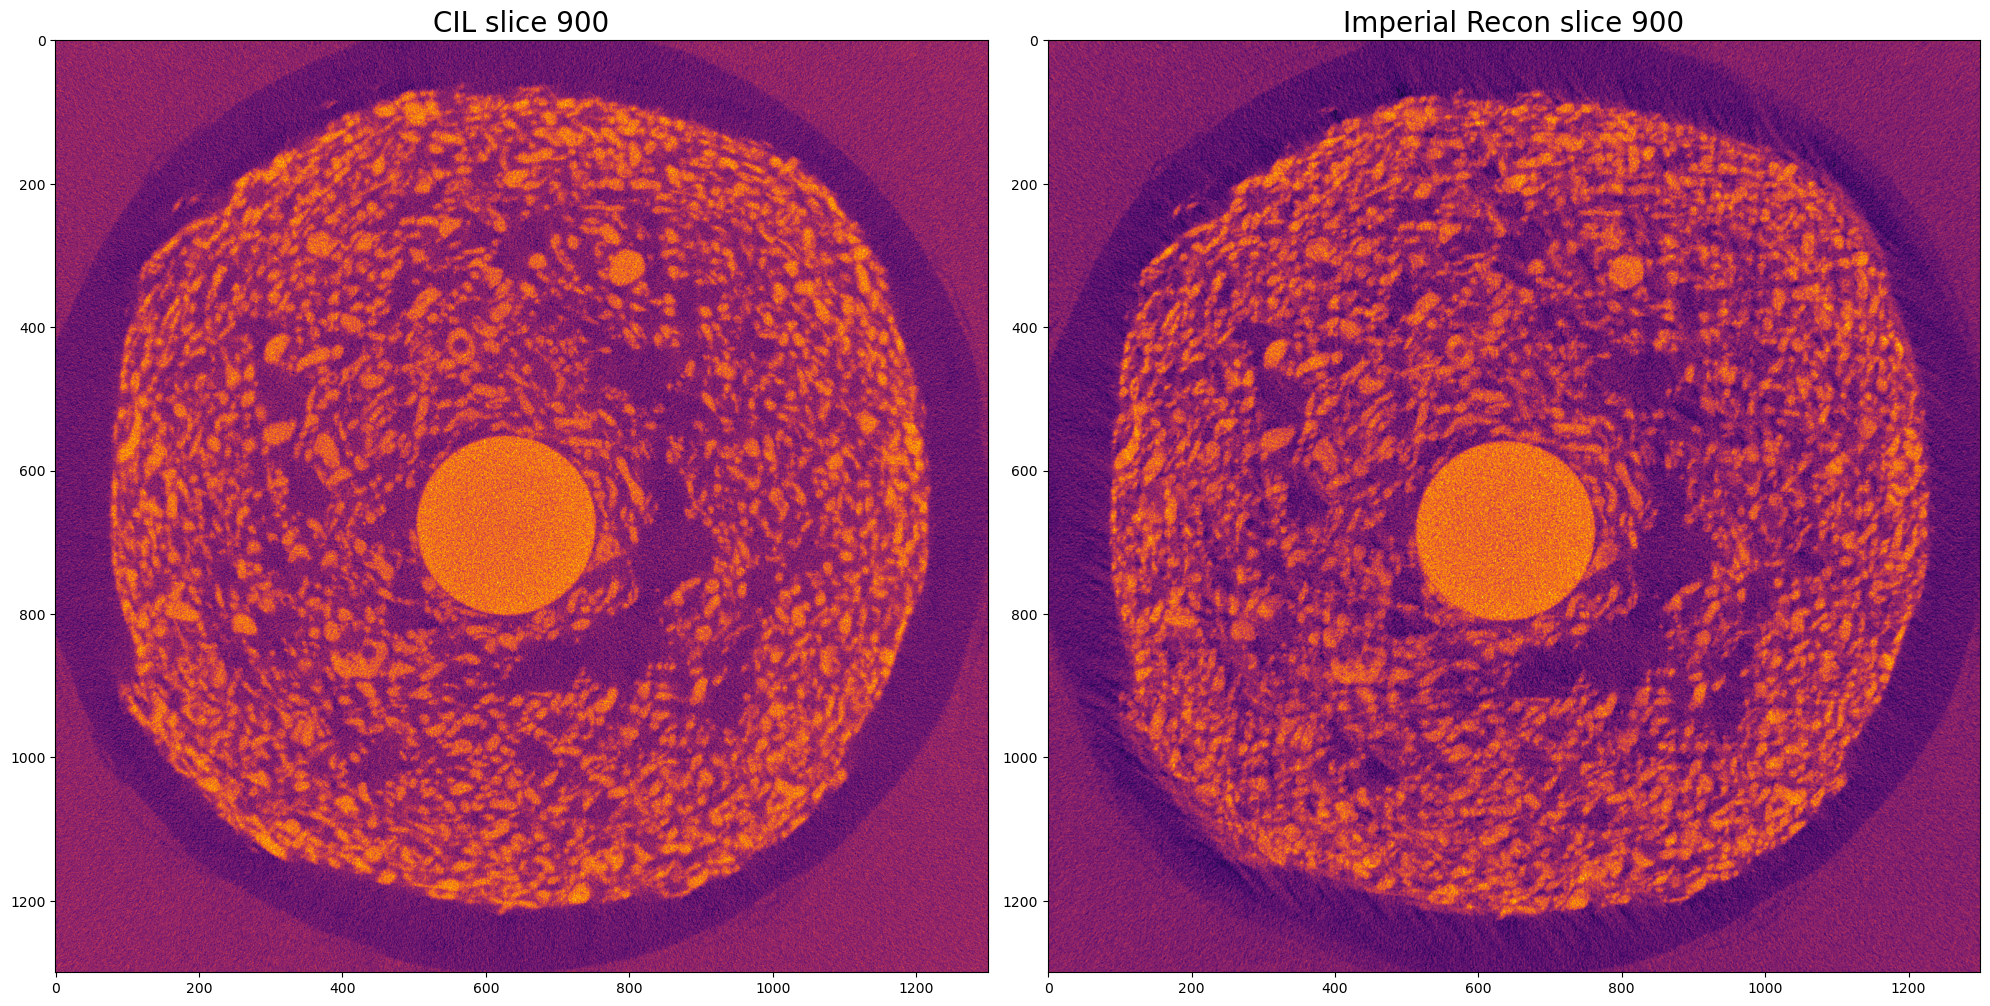

In [11]:
num_slice = 900
from PIL import Image

# path = r"P:\Antony\RSIF\microct\Imperial\Energizer_AAA_binning1_1s_ROI_3600\Scan2\scan2_recon"
path = r"Z:\Users\Antony\RSIF\microct\Imperial\Energizer_AAA_binning1_1s_ROI_3600\Scan2\scan2_recon"
name = "scan2_recon0{}.tif".format(num_slice)

im = Image.open(os.path.join(path, name))
zz = np.array(im)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(fdk_recon.array[-num_slice], cmap="inferno")
axs[0].set_title('CIL slice {}'.format(num_slice), fontsize=20)


axs[1].imshow(np.fliplr(np.flipud(zz[500:1800,500:1800])), cmap="inferno")
axs[1].set_title('Imperial Recon slice {}'.format(num_slice), fontsize=20)

plt.tight_layout()

plt.show()